In [10]:
import torch
import torch.nn as nn

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        return hidden

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, state = self.lstm(x, hidden)
        x = self.linear(x)
        return x, state

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.decoder(encoder_inputs))

In [14]:
import random

soundmark = ['Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo', 'Foxtrot', 'Golf', 'Hotel', 'India', 'Juliett', 'Kilo',
             'Lima', 'Mike', 'November', 'Oscar', 'Papa', 'Quebec', 'Romeo', 'Sierra', 'Tango', 'Uniform', 'Victor',
             'Whiskey', 'X-ray', 'Yankee', 'Zulu']

alphabet = [chr(x) for x in range(ord('a'), ord('z') + 1)]

t = 10000
r = 0.9
seq_len = 6
source_tokens = []
target_tokens = []

for i in range(t):
    source, target = [], []
    for j in range(seq_len):
        ind = random.randint(0, 25)
        source.append(soundmark[ind])
        if random.random() < r:
            target.append(alphabet[ind])
        else:
            target.append(alphabet[random.randint(0, 25)])
    source_tokens.append(source)
    target_tokens.append(target)

source_tokens[:2], target_tokens[:2]

([['Quebec', 'Echo', 'Echo', 'Foxtrot', 'Whiskey', 'X-ray'],
  ['Papa', 'Bravo', 'Foxtrot', 'Tango', 'India', 'Echo']],
 [['q', 'e', 'e', 'f', 'w', 'x'], ['p', 'b', 'f', 't', 'i', 'e']])

In [15]:
from collections import Counter

flatten = lambda l: [item for sublist in l for item in sublist]

class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens
        self.token2index = {'<bos>': 0, '<eos>': 1}
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        })
        self.index2token = {index: token for token, index in self.token2index.items()}

    def __getitem__(self, query):
       if isinstance(query, (str, int)):
           if isinstance(query, str):
               return self.token2index.get(query, 0)
           elif isinstance(query, (int)):
               return self.token2index.get(query, '<unk>')
       elif isinstance(query, (list, tuple)):
           return [self.__getitem__(item) for item in query]

    def __len__(self):
        return len(self.token2index)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

source_vocab, target_vocab = Vocab(source_tokens), Vocab(target_tokens)

source_data = torch.tensor([source_vocab[line + ['<eos>']] for line in source_tokens])
target_data = torch.tensor([target_vocab[line + ['<eos>']] for line in target_tokens])

train_size = int(len(source_data) * 0.8)
test_size = len(source_data) - train_size
batch_size = 16

train_loader = DataLoader(TensorDataset(source_data[:train_size], target_data[:train_size]), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(source_data[-test_size:], target_data[-test_size:]), batch_size=1)

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers=num_layers)

    def forward(self, encoder_inputs):
        encoder_inputs = self.embedding(encoder_inputs).permute(1, 0, 2)
        output, hidden = self.gru(encoder_inputs)
        return hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        # input_size = embedding_size + hidden_size
        self.gru = nn.GRU(emb_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, decoder_inputs, encoder_states):
        decoder_inputs = self.embedding(decoder_inputs).permute(1, 0, 2)
        context = encoder_states[-1]
        # (batch_size, hidden_size) -> (seq_len, batch_size, hidden_size) size transformation
        context = context.repeat(decoder_inputs.shape[0], 1, 1)
        output, hidden = self.gru(torch.cat((decoder_inputs, context), -1), encoder_states)
        # logits -> (seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

In [18]:
emb = nn.Embedding(26, 26)
emb(train_loader.dataset[0][0])

tensor([[-2.4491e-01,  4.1067e-01, -2.8609e-02,  2.7211e-01, -8.1178e-01,
          5.4249e-01,  1.1223e+00, -1.4381e-01, -2.5499e-03,  2.1179e-01,
         -1.2077e+00,  1.3965e-01, -1.4300e-01,  1.9296e+00,  1.2456e+00,
          5.8505e-01, -1.5287e+00,  3.4248e-01,  1.8835e+00,  6.0511e-01,
         -5.2181e-01, -5.2403e-01,  1.0484e+00,  2.2871e-01, -1.8105e-01,
         -1.6474e-01],
        [ 9.5505e-01, -2.7516e-01,  9.3353e-02, -1.0070e+00, -1.5449e+00,
          1.2799e-01, -5.1902e-01, -1.7818e-01,  1.5129e+00, -5.3505e-01,
          1.4554e+00,  4.5273e-01, -1.3022e+00,  4.4230e-02,  5.3929e-02,
          2.7778e-01,  8.4415e-01, -8.1049e-01,  9.0950e-01,  1.4166e+00,
          6.9952e-01, -1.5719e+00, -5.4260e-01,  7.3122e-01, -4.5539e-01,
         -7.2414e-01],
        [ 9.5505e-01, -2.7516e-01,  9.3353e-02, -1.0070e+00, -1.5449e+00,
          1.2799e-01, -5.1902e-01, -1.7818e-01,  1.5129e+00, -5.3505e-01,
          1.4554e+00,  4.5273e-01, -1.3022e+00,  4.4230e-02,  5.39

In [19]:
from tqdm import *
import matplotlib.pyplot as plt

lr = 0.001
num_epochs = 20
hidden_size = 128

encoder = Encoder(len(source_vocab), len(source_vocab), hidden_size, num_layers=2)
decoder = Decoder(len(target_vocab), len(target_vocab), hidden_size, num_layers=2)
model = Seq2Seq(encoder, decoder)

loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history = []

model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs, decoder_targets in train_loader:
        # encoder_inputs, decoder_targets = encoder_inputs, decoder_targets
        bos_column = torch.tensor([target_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1, 1)
        decoder_inputs = torch.cat((bos_column, decoder_targets[:, :-1]), dim=1)
        # pred's shape -> (seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_inputs, decoder_inputs)
        # decoder_targets's shape -> (batch_size, seq_len)
        # loss shape -> (batch_size, seq_len)
        loss = loss_fn(pred.permute(1, 2, 0), decoder_targets).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())


100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


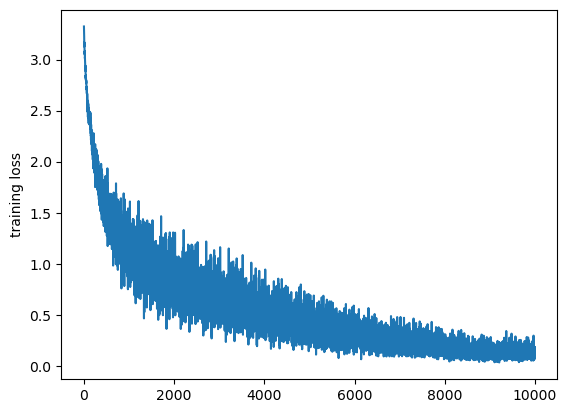

In [21]:
plt.plot(loss_history)
plt.ylabel('training loss')
plt.show()

In [22]:
model.eval()
translation_results = []

correct = 0
error = 0

for source_seq, target_seq in test_loader:
    encoder_inputs = source_seq
    hidden = model.encoder(encoder_inputs)
    pred_seq = [target_vocab['<bos>']]

    for _ in range(8):
        # Shape of decoder input is (batch_size, seq_len) = (1, 1)
        decoder_inputs = torch.tensor(pred_seq[-1]).reshape(1, 1)
        # Shape of pred -> (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_inputs, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == target_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)

    # Remove the leading <bos>
    pred_seq = target_vocab[pred_seq[1:]]
    target_seq = target_seq.squeeze().tolist()

    if target_vocab['<eos>'] in target_seq:
        eos_idx = target_seq.index(target_vocab['<eos>'])
        target_seq = target_vocab[target_seq[:eos_idx]]
    else:
        target_seq = target_vocab[target_seq]
    translation_results.append((' '.join(target_seq), ' '.join(pred_seq)))

    for i in range(len(target_seq)):
        if i >= len(pred_seq) or pred_seq[i] != target_seq[i]:
            error += 1
        else:
            correct += 1

print(correct / (correct + error))

0.9935833333333334


In [ ]:
translation_results